# W261 Final Project - Experiment, Fine-Tune, Select the Optimal Pipeline (Coding Notebook - Logistics Baseline Model)
## Section 02, Team 1: Aimee, Dylan, Jo, Vicky

In [0]:
# read datasets
section = "02"
number = "01"
folder_path = f"dbfs:/student-groups/Group_{section}_{number}"

# Read the checkpointed train and test datasets
df_train_downsampled = spark.read.parquet(f"{folder_path}/df_train_downsampled.parquet")
df_test = spark.read.parquet(f"{folder_path}/df_test.parquet")
df_train = spark.read.parquet(f"{folder_path}/df_train.parquet")

# Setup & Directory

In [0]:
# Basic Functions
from pyspark.sql import functions as F
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import isnan, when, count, col, isnull, percent_rank
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType, ShortType, DateType, BooleanType, BinaryType, FloatType
 
# For feature engineering
from pyspark.ml.feature import StandardScaler, VectorAssembler, VectorIndexer, StringIndexer, OneHotEncoder, ChiSqSelector, Bucketizer, Imputer, MinMaxScaler,FeatureHasher
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.window import Window
from pyspark.streaming import StreamingContext
from pyspark.sql import Row
from functools import reduce
from pyspark.sql.functions import rand,col,when,concat,substring,lit,udf,lower,sum as ps_sum,count as ps_count,row_number
from pyspark.sql.window import *
from pyspark.sql import DataFrame
from pyspark.ml.feature import VectorAssembler,BucketedRandomProjectionLSH,VectorSlicer
from pyspark.ml.linalg import Vectors,VectorUDT
from pyspark.sql.functions import array, create_map, struct
from itertools import product
 
# For EDA/plotting & basic funcs
import pandas as pd
import numpy as np
pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", 200)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1, style='whitegrid')
import random
from math import floor
 
# For Modeling
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, LinearSVC, RandomForestClassifier, GBTClassifier, NaiveBayes
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from sklearn.metrics import classification_report
import itertools 
from xgboost.spark import SparkXGBClassifier

In [0]:
# read datasets
section = "02"
number = "01"
folder_path = f"dbfs:/student-groups/Group_{section}_{number}"

df_otpw_60m = spark.read.parquet(f"{folder_path}/otpw_60m_proceed.parquet")

In [0]:
print(df_train_downsampled.filter(F.col("HourlyPrecipitation").isNull()).count())
print(df_train_downsampled.filter(F.col("HourlySeaLevelPressure").isNull()).count())
print(df_train_downsampled.filter(F.col("HourlyWindGustSpeed").isNull()).count())

0
0
0


In [0]:
# print the size of df_otpw_60m dataset before dropping duplicates
print("Size of df_otpw_60m:", df_otpw_60m.count())

# drop duplicates in df_otpw_60m dataset
df_otpw_60m = df_otpw_60m.dropDuplicates()

# print the size of df_otpw_60m dataset after dropping duplicates
print("Size of df_otpw_60m:", df_otpw_60m.count())

Size of df_otpw_60m: 31179957
Size of df_otpw_60m: 31175565


In [0]:
# print the size of df_otpw_60m dataset before dropping duplicates
print("Size of df_train_downsampled:", df_train_downsampled.count())

# drop duplicates in df_otpw_60m dataset
df_train_downsampled = df_train_downsampled.dropDuplicates()

# print the size of df_otpw_60m dataset after dropping duplicates
print("Size of df_train_downsampled:", df_train_downsampled.count())

Size of df_train_downsampled: 8622415
Size of df_train_downsampled: 8622415


Our primary customer is the consumer.  As a result, we will focus on predicting departure delays (no delay), where a delay is defined as a 15-minute delay (or greater) concerning the planned departure time. This prediction should be made two hours before departure (thereby giving airlines and airports time to regroup and give passengers a heads-up on a delay). You need to decide how to tackle the problem, either as a Regression problem or as a Classification problem. You need to select which metric should you focus on: F1-Beta, sensitivity, specificity, MSE, R2, etc.


Create machine learning baseline pipelines using logistic/linear regression and ensemble models and do experiments on  the following:
 - Three-month ATPW dataset (this is optional but is a great stepping stone towards the one-year dataset)
 - One-year ATPW dataset
 - Log and report on experimental results (with a primary focus on the one-year ATPW dataset)
     - For the one-year ATPW dataset, please use the last quarter of the available one-year dataset as a blind test set that is never consulted during training. --> train-test split: 75%/25%
     - Report  evaluation metrics in terms of **cross-fold validation** over the training set (first three-quarters of the one-year of ATPW dataset)
     - Report evaluation metrics in terms of the blind test set.
- Discuss experimental results and main findings




Train/test/validation set

Create machine learning baseline pipelines using logistic/linear regression and ensemble models and do experiments on  the following:

- One-year ATPW dataset
- Log and report on experimental results (with a primary focus on the one-year ATPW dataset)
- For the one-year ATPW dataset, please use the last quarter of the available one-year dataset as a blind test set that is never consulted during training.
Report  evaluation metrics in terms of cross-fold validation over the training set (first three-quarters of the one-year of ATPW dataset)


Report evaluation metrics in terms of the blind test set.

Discuss experimental results and main findings.

Fine-tune your baseline pipeline using a grid search
Is there a difference in performance? Is it related to features? Is it related to noise? What is impacting the model performance?

In [0]:
df_otpw_60m.dtypes

[('DEST', 'string'),
 ('ORIGIN', 'string'),
 ('OP_CARRIER_AIRLINE_ID', 'string'),
 ('ORIGIN_STATE_ABR', 'string'),
 ('DEST_STATE_ABR', 'string'),
 ('DEP_DEL15', 'int'),
 ('DIVERTED', 'string'),
 ('DISTANCE_GROUP', 'string'),
 ('MONTH', 'string'),
 ('origin_type', 'string'),
 ('dest_type', 'string'),
 ('dest_airport_lat', 'double'),
 ('dest_airport_lon', 'double'),
 ('sched_depart_date_time_UTC', 'timestamp'),
 ('HourlyDryBulbTemperature', 'double'),
 ('HourlyPrecipitation', 'double'),
 ('HourlyPressureChange', 'double'),
 ('HourlyPressureTendency', 'double'),
 ('HourlyRelativeHumidity', 'double'),
 ('HourlySeaLevelPressure', 'double'),
 ('HourlyStationPressure', 'double'),
 ('HourlyVisibility', 'double'),
 ('HourlyWindGustSpeed', 'double'),
 ('HourlyWindSpeed', 'double'),
 ('prev_flight_delay_ind', 'int'),
 ('is_holiday', 'int'),
 ('is_weekend', 'int'),
 ('origin_pagerank', 'double'),
 ('dest_pagerank', 'double')]

# Train-Test Split on  12 Month Data

In [0]:
# # Remove null values in the target variable
# df_otpw_60m = df_otpw_60m.filter(F.col("DEP_DEL15").isNotNull())

# # Train-Test Split based on the last 3 months of the year
# df_train = df_otpw_60m.filter(col("DATE") < "2019-01-01 00:00:00")  # Data before October 1, 2015
# df_test = df_otpw_60m.filter(col("DATE") >= "2019-01-01 00:00:00")  # Data from October 1, 2015, onwards

# print("Training Set Size:", df_train.count())
# print("Test Set Size:", df_test.count())

# # Save the train-test splits
# # df_train.write.mode("overwrite").parquet(f"{folder_path}/otpw_12m_train.parquet")
# # df_test.write.mode("overwrite").parquet(f"{folder_path}/otpw_12m_test.parquet")


In [0]:
# #downsampling
# def downsample(train_df,verbose=False):
#   '''Downsamples train_df to balance classes'''
#   #balance classes in train
#   delay_count = train_df.filter(F.col("DEP_DEL15") == 1).count()
#   non_delay_count = train_df.filter(F.col("DEP_DEL15") == 0).count()
 
#   total = delay_count + non_delay_count
#   keep_percent = delay_count / non_delay_count
  
#   train_delay = train_df.filter(F.col('DEP_DEL15') == 1)
#   train_non_delay = train_df.filter(F.col('DEP_DEL15') == 0).sample(withReplacement=False,fraction=keep_percent,seed=42)
#   train_downsampled = train_delay.union(train_non_delay)
#   return train_downsampled

# df_train_downsampled = downsample(df_train).dropna().cache()
# df_train_downsampled_3m = downsample(df_train_3m).cache()
df_train_downsampled.groupBy("DEP_DEL15").count().show()

+---------+-------+
|DEP_DEL15|  count|
+---------+-------+
|        1|4311870|
|        0|4310545|
+---------+-------+



In [0]:
df_train_downsampled.limit(10).toPandas().head()

,DEST,ORIGIN,OP_CARRIER_AIRLINE_ID,ORIGIN_STATE_ABR,DEST_STATE_ABR,DEP_DEL15,DIVERTED,DISTANCE_GROUP,MONTH,origin_type,dest_type,dest_airport_lat,dest_airport_lon,sched_depart_date_time_UTC,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPressureChange,HourlyPressureTendency,HourlyRelativeHumidity,HourlySeaLevelPressure,HourlyStationPressure,HourlyVisibility,HourlyWindGustSpeed,HourlyWindSpeed,prev_flight_delay_ind,is_holiday,is_weekend,origin_pagerank,dest_pagerank
0,CVG,LAS,20368,NV,KY,1,0.0,7,5,large_airport,large_airport,39.0,-84.7,2018-05-24 22:27:00,88.0,0.0,0.0100,5.0,8.0,29.79,27.59,10.0,18.00000,11.0,1,0,0,5.472447,2.431608
1,LCK,SFB,20368,FL,OH,1,0.0,4,7,large_airport,large_airport,39.8,-82.9,2018-07-25 12:05:00,85.0,0.0,0.0023,-1.0,77.0,29.97,29.91,10.0,25.23832,9.0,0,0,0,3.712784,0.592810
2,EWR,PWM,20366,ME,NJ,1,0.0,2,10,large_airport,large_airport,40.7,-74.2,2016-10-24 14:44:00,54.0,0.0,0.0100,8.0,37.0,29.72,29.66,10.0,31.00000,21.0,0,0,0,0.795083,4.144858
3,MFE,IAH,20366,TX,TX,1,0.0,2,10,large_airport,medium_airport,26.2,-98.3,2017-10-14 19:45:00,89.0,0.0,0.0023,-1.0,55.0,29.97,29.86,10.0,25.23832,14.0,0,0,1,5.946030,0.402403
4,OKC,IAH,20366,TX,OK,1,0.0,2,3,large_airport,large_airport,35.4,-97.6,2018-03-02 15:40:00,71.0,0.0,0.0100,8.0,59.0,30.27,30.16,10.0,25.23832,9.0,0,0,0,5.946030,1.559203


# Logistic Regression

`model = build_model(_alpha=1.0, _l1_ratio=0.3)`

`btscv = BlockingTimeSeriesSplit(n_splits=5)` 

`scores = cross_val_score(model, X_train, y_train, cv=btscv, scoring=r2)`

`print("Loss: {0:.3f} (+/- {1:.3f})".format(scores.mean(), scores.std()))`

In [0]:
# count null values per column in df_otpw_3m
# df_3m_nonulls = df_otpw_3m.filter(F.col("cancelled") != 1).dropna().cache()
df_train_downsampled.limit(10).toPandas().head()

,DEST,ORIGIN,OP_CARRIER_AIRLINE_ID,ORIGIN_STATE_ABR,DEST_STATE_ABR,DEP_DEL15,DIVERTED,DISTANCE_GROUP,MONTH,origin_type,dest_type,dest_airport_lat,dest_airport_lon,sched_depart_date_time_UTC,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPressureChange,HourlyPressureTendency,HourlyRelativeHumidity,HourlySeaLevelPressure,HourlyStationPressure,HourlyVisibility,HourlyWindGustSpeed,HourlyWindSpeed,prev_flight_delay_ind,is_holiday,is_weekend,origin_pagerank,dest_pagerank
0,BNA,ORD,20366,IL,TN,0,0.0,2,2,large_airport,large_airport,36.1,-86.7,2015-02-23 00:01:00,6.0,0.0,-0.0800,1.0,57.0,30.66,29.88,10.0,25.23832,11.0,0,0,0,11.044592,2.871478
1,IAH,LFT,20366,LA,TX,0,0.0,1,8,large_airport,large_airport,30.0,-95.4,2015-08-04 00:09:00,82.0,0.0,-0.0300,3.0,82.0,29.91,29.86,10.0,25.23832,0.0,0,0,0,0.413554,5.946030
2,SCE,ORD,20366,IL,PA,0,0.0,3,8,large_airport,medium_airport,40.8,-77.8,2016-08-10 19:14:00,88.0,0.0,0.0023,-1.0,48.0,30.03,29.32,10.0,25.23832,11.0,0,0,0,11.044592,0.475330
3,ECP,IAH,20366,TX,FL,0,0.0,3,1,large_airport,medium_airport,30.3,-85.8,2017-01-20 01:10:00,61.0,0.0,-0.0100,1.0,93.0,29.77,29.67,7.0,25.23832,3.0,0,0,0,5.946030,0.764352
4,JAN,IAH,20366,TX,MS,0,0.0,2,5,large_airport,large_airport,32.3,-90.1,2018-05-27 21:45:00,86.0,0.0,0.0100,6.0,65.0,29.78,29.67,10.0,25.23832,14.0,0,1,1,5.946030,0.587401


# Define helper Functions

In [0]:
def lr_pipeline_non_hash(model):
    """
    Pipeline for Logistic regression
    """
    # List of categorical columns to be indexed
    categoricals = ['DEST','ORIGIN','OP_CARRIER_AIRLINE_ID','ORIGIN_STATE_ABR','DEST_STATE_ABR','DIVERTED', 'DISTANCE_GROUP','MONTH', 'origin_type', 'dest_type','prev_flight_delay_ind','is_holiday','is_weekend']

    numerics= ["dest_airport_lat",'dest_airport_lon',"HourlyDryBulbTemperature","HourlyPrecipitation",'HourlyPressureTendency',"HourlyRelativeHumidity","HourlySeaLevelPressure","HourlyStationPressure","HourlyVisibility","HourlyWindGustSpeed","HourlyWindSpeed",'origin_pagerank','dest_pagerank']

    indexers = StringIndexer(inputCols=categoricals,
                             outputCols=[categorical + "_idx" for categorical in categoricals])\
                                 .setHandleInvalid("keep")

    ohes = OneHotEncoder(inputCols=[categorical + "_idx" for categorical in categoricals],
                         outputCols=[categorical + "_ohe" for categorical in categoricals]
                         )

    catgorical_assembler = VectorAssembler(inputCols=[categorical + "_ohe" for categorical in categoricals],
                                           outputCol="catgorical_features")

    numeric_assembler = VectorAssembler(inputCols=numerics,
                                        outputCol="numeric_features")

    target = StringIndexer(inputCols=["DEP_DEL15"],outputCols=['label'])

    all_features = ["catgorical_features", "numeric_features"]
    
    assembler = VectorAssembler(inputCols=all_features,
                                outputCol="features")

    # Build the stage for the ML pipeline
    stages = [indexers, ohes, catgorical_assembler, numeric_assembler, target, assembler, model]

    # Build our ML pipeline
    pipeline = Pipeline(stages=stages)

    return pipeline

In [0]:
def lr_pipeline(model):
    """
    Pipeline for Logistic regression
    """
    # List of categorical columns to be indexed
    categoricals = ['DEST','ORIGIN','OP_CARRIER_AIRLINE_ID','ORIGIN_STATE_ABR','DEST_STATE_ABR','DIVERTED', 'DISTANCE_GROUP','MONTH', 'origin_type', 'dest_type','prev_flight_delay_ind','is_holiday','is_weekend']

    numerics= ["dest_airport_lat",'dest_airport_lon',"HourlyDryBulbTemperature","HourlyPrecipitation",'HourlyPressureTendency',"HourlyRelativeHumidity","HourlySeaLevelPressure","HourlyStationPressure","HourlyVisibility","HourlyWindGustSpeed","HourlyWindSpeed",'origin_pagerank','dest_pagerank']

    indexers = StringIndexer(inputCols=categoricals,
                             outputCols=[categorical + "_idx" for categorical in categoricals])\
                                 .setHandleInvalid("keep")

    # Use FeatureHasher for hashing categorical columns
    hasher = FeatureHasher(inputCols=[f"{c}_idx" for c in categoricals], 
                           outputCol="hashed_features", numFeatures=500)

    catgorical_assembler = VectorAssembler(inputCols=[categorical + "_idx" for categorical in categoricals],
                                           outputCol="catgorical_features")

    numeric_assembler = VectorAssembler(inputCols=numerics,
                                        outputCol="numeric_features")

    target = StringIndexer(inputCols=["DEP_DEL15"],outputCols=['label'])

    all_features = ["catgorical_features", "numeric_features"]
    
    assembler = VectorAssembler(inputCols=all_features,
                                outputCol="features")

    # Build the stage for the ML pipeline
    stages = [indexers, hasher,catgorical_assembler, numeric_assembler, target, assembler, model]

    # Build our ML pipeline
    pipeline = Pipeline(stages=stages)

    return pipeline

In [0]:
def get_model(model_type, pipeline_func, p):
  """
  Input: name of model, the pipeline function for that model and a set of parameters
  Output: a pipeline object for the input model type
  """
  if model_type == 'gbt':
    gbt = GBTClassifier(labelCol="DEP_DEL15",
                        featuresCol="features",
                        maxDepth=p[0],
                        maxBins=p[1],
                        maxIter=p[2],
                        stepSize=p[3])
    pipeline = pipeline_func(gbt)
    
  elif model_type == 'xgboost':
    xgboost = SparkXGBClassifier(
        label_col="DEP_DEL15",  # Ensure this is the target column for classification (binary or multi-class labels)
        features_col="features",  # The feature column
        missing=0.0,
        raw_prediction_col='probability',  # This is for storing the prediction probabilities in classification tasks
        max_depth=p["max_depth"],
        n_estimators=p["n_estimators"],
        reg_lambda=p["reg_lambda"],
        reg_alpha=p["reg_alpha"],
        base_score=p["base_score"],
        learning_rate=p["learning_rate"],
        gamma=p["gamma"],
        scale_pos_weight=p["scale_pos_weight"],
        min_child_weight=p["min_child_weight"],
        tree_method=p["tree_method"],  # Fetching from dictionary
        num_workers=p["num_workers"]   # Fetching from dictionary
    )
    pipeline = pipeline_func(xgboost)

  elif model_type == 'lr':
      # Use logistic regression 
      lr = LogisticRegression(maxIter=p['maxIter'],
                              elasticNetParam=p['elasticNetParam'],
                              regParam=p['regParam'],
                              featuresCol="features",
                              labelCol='label')
      
      pipeline = pipeline_func(lr)
      
    
  return pipeline

In [0]:
def evaluate_classification_model(prediction, label_col="DEP_DEL15", prediction_col="prediction"):
    
    # Select predictions and actual labels
    predictions_and_labels = prediction.select(prediction_col, label_col)

    # For binary classification (precision, recall, F1):
    binary_evaluator = BinaryClassificationEvaluator(labelCol=label_col, rawPredictionCol=prediction_col)
    
    # Calculate True Positives, False Positives, True Negatives, and False Negatives
    TP = predictions_and_labels.filter((col(prediction_col) == 1) & (col(label_col) == 1)).count()  # True Positive
    FP = predictions_and_labels.filter((col(prediction_col) == 1) & (col(label_col) == 0)).count()  # False Positive
    TN = predictions_and_labels.filter((col(prediction_col) == 0) & (col(label_col) == 0)).count()  # True Negative
    FN = predictions_and_labels.filter((col(prediction_col) == 0) & (col(label_col) == 1)).count()  # False Negative
    
    # Calculate evaluation metrics
    beta = 2
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0.0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0.0
    f2_score = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall) if (precision + recall) != 0 else 0.0
    roc_auc = binary_evaluator.setMetricName("areaUnderROC").evaluate(prediction)
    pr_auc = binary_evaluator.setMetricName("areaUnderPR").evaluate(prediction)

    # Create confusion matrix as a 2x2 array
    conf_matrix = np.array([[TN, FP], 
                            [FN, TP]])

    # Convert to Pandas DataFrame
    conf_matrix_df = pd.DataFrame(conf_matrix, 
                                index=["Actual Negative (0)", "Actual Positive (1)"], 
                                columns=["Predicted Negative (0)", "Predicted Positive (1)"])

    # Plot the confusion matrix with color bar
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues", cbar=True)  # cbar=True adds side bar
    plt.title("Confusion Matrix")
    plt.ylabel("Actual Label")
    plt.xlabel("Predicted Label")
    plt.show()
    
    return precision, recall, f1_score, f2_score, roc_auc, pr_auc

In [0]:
def evaluate_classification_model_train_test(prediction, label_col="DEP_DEL15", prediction_col="prediction",evaluation_type="train"):
    
    # Select predictions and actual labels
    predictions_and_labels = prediction.select(prediction_col, label_col)

    # For binary classification (precision, recall, F1):
    binary_evaluator = BinaryClassificationEvaluator(labelCol=label_col, rawPredictionCol=prediction_col)
    
    # Calculate True Positives, False Positives, True Negatives, and False Negatives
    TP = predictions_and_labels.filter((col(prediction_col) == 1) & (col(label_col) == 1)).count()  # True Positive
    FP = predictions_and_labels.filter((col(prediction_col) == 1) & (col(label_col) == 0)).count()  # False Positive
    TN = predictions_and_labels.filter((col(prediction_col) == 0) & (col(label_col) == 0)).count()  # True Negative
    FN = predictions_and_labels.filter((col(prediction_col) == 0) & (col(label_col) == 1)).count()  # False Negative
    
    # Calculate evaluation metrics
    beta = 2
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0.0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0.0
    f2_score = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall) if (precision + recall) != 0 else 0.0
    roc_auc = binary_evaluator.setMetricName("areaUnderROC").evaluate(prediction)
    pr_auc = binary_evaluator.setMetricName("areaUnderPR").evaluate(prediction)

    # Create confusion matrix as a 2x2 array
    conf_matrix = np.array([[TN, FP], 
                            [FN, TP]])

    # Convert to Pandas DataFrame
    conf_matrix_df = pd.DataFrame(conf_matrix, 
                                index=["Actual Negative (0)", "Actual Positive (1)"], 
                                columns=["Predicted Negative (0)", "Predicted Positive (1)"])

    # Plot the confusion matrix with color bar
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues", cbar=True)  # cbar=True adds side bar
    if evaluation_type == 'train':
        plt.title("Confusion Matrix (Train Set)")
    else:
        plt.title("Confusion Matrix (Test Set)")
    plt.ylabel("Actual Label")
    plt.xlabel("Predicted Label")
    plt.show()
    
    return precision, recall, f1_score, f2_score, roc_auc, pr_auc

In [0]:
# Cross-fold Validation

from pyspark.sql import functions as F
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
import numpy as np
import pandas as pd

class BlockedTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits

    def get_n_splits(self, df):
        return self.n_splits

    def split(self, df):
        df_sorted = df.orderBy('sched_depart_date_time_UTC').cache()
        timestamps = df_sorted.select("sched_depart_date_time_UTC").rdd.map(lambda r: r[0]).collect()
        n_samples = len(timestamps)
        split_size = n_samples // self.n_splits

        for i in range(self.n_splits):
            start_idx = i * split_size
            stop_idx = min(start_idx + split_size, n_samples)
            mid_idx = start_idx + int(0.8 * (stop_idx - start_idx))

            train_start = timestamps[start_idx]
            train_end = timestamps[mid_idx - 1]
            val_start = timestamps[mid_idx]
            val_end = timestamps[stop_idx - 1]

            train_data = df.filter((F.col("sched_depart_date_time_UTC") >= train_start) &
                                (F.col("sched_depart_date_time_UTC") <= train_end)).cache()

            val_data = df.filter((F.col("sched_depart_date_time_UTC") > train_end) &
                                (F.col("sched_depart_date_time_UTC") <= val_end)).cache()

            yield train_data, val_data


def cross_validate_with_blocked_time_series_split(models, df, n_splits):
    
    evaluator = BinaryClassificationEvaluator(labelCol="DEP_DEL15") 
    
    # Initialize the blocked time series split
    splitter = BlockedTimeSeriesSplit(n_splits)
    
    # Initialize dictionary to store evaluation results
    results = {model_name: {
        "precision": [],
        "recall": [],
        "f1_score": [],
        "f2_score": [],
        "roc_auc": [],
        "pr_auc": []
    } for model_name in models.keys()}
    
    # Cross-validation loop for each model
    for model_name, model in models.items():
        # Perform split and evaluate for each fold
        for train_data, val_data in splitter.split(df):
            # Create a pipeline for training
            pipeline = get_model(model_name, lr_pipeline, model)  
            
            # Train the model using training data
            trained_model = pipeline.fit(train_data)
            
            # Make predictions on validation data
            predictions = trained_model.transform(val_data)
            
            # Evaluate the model with binary classification evaluator
            precision, recall, f1_score, f2_score, roc_auc, pr_auc = evaluate_classification_model(predictions)
            
            # Store the evaluation metrics for each fold
            results[model_name]["precision"].append(precision)
            results[model_name]["recall"].append(recall)
            results[model_name]["f1_score"].append(f1_score)
            results[model_name]["f2_score"].append(f2_score)
            results[model_name]["roc_auc"].append(roc_auc)
            results[model_name]["pr_auc"].append(pr_auc)

        for metric in results[model_name]:
            # Calculate the average of the metric across all folds
            results[model_name][metric] = np.mean(results[model_name][metric])
        
    return results





In [0]:
print(df_train_downsampled.count())
print(df_train_downsampled.dropna().count())

df_train_downsampled.dropna().count() / df_train_downsampled.count()

8622415
8608790


0.9984198162579742

In [0]:
p = {'elasticNetParam': .05,
     'maxIter' : 10,
     'regParam':0.01}

df_train_downsampled = df_train_downsampled.dropna()

model_type = 'lr'
pipeline = get_model(model_type, lr_pipeline, p)

lr_model_60m = pipeline.fit(df_train_downsampled)

In [0]:
# Assuming you have the models
models = {'lr': p}

# Assuming 'df_train_3m' is the full dataframe containing both features and target columns
# Perform cross-validation
results = cross_validate_with_blocked_time_series_split(models, df_train_downsampled, n_splits=5)

print(results)

In [0]:
def timeSeriesSplitCV_old(dataset, param_grid, pipeline_func, model_type, k=3, blocking=False, sampling=None, metric='f2', verbose=True):
  '''
  Perform timSeriesSplit k-fold cross validation 
  '''
  # Initiate trackers
  best_score = 0
  best_param_vals = None
   
  df=dataset
  n=df.count()
  df = df.withColumn("row_id", F.row_number().over(Window.partitionBy().orderBy("sched_depart_date_time_UTC")))
  chunk_size = int(n/(k+1))
  
  parameter_names, parameters = parameter_sets(param_grid)
  print('')
  print(f'Number of validation datapoints for each fold is {chunk_size:,}')
  print("************************************************************")
  
  if len(parameters) == 1:
    print('you only entered one set of parameters you doofus')
  
  for p in parameters:
    p= dict(zip(parameter_names, p))
    pipeline = get_model(model_type, pipeline_func, p)
    
    # Print parameter set
    param_print = {key: value for key, value in p.items()}
    print(f"Parameters: {param_print}")
    
    # Track score
    scores=[]
    
    # Start k-fold
    for i in range(k):
      
      # If TimeseriesSplit 
      if not blocking:
        train_df = df.filter(F.col('row_id') <= chunk_size * (i+1)).cache()
      # If BlockingSplit
      else:
        train_df = df.filter((F.col('row_id') > chunk_size * i)&(F.col('row_id') <= chunk_size * (i+1))).cache()
        
      # Create dev set
      dev_df = df.filter((F.col('row_id') > chunk_size * (i+1))&(F.col('row_id') <= chunk_size * (i+2))).cache()  
        
      #print info on train and dev set for this fold
      if verbose:
        print('    TRAIN set for fold {} goes from {} to {}, count is {:,} flights ({})'.format((i+1), 
              train_df.agg({'DATE':'min'}).collect()[0][0],
              train_df.agg({'DATE':'max'}).collect()[0][0],
              train_df.count(),
              sampling + '-sampled' if sampling else 'no sampling'))
        print('    DEV set for fold {} goes from {} to {}, count is {:,} flights'.format((i+1), 
              dev_df.agg({'DATE':'min'}).collect()[0][0],
              dev_df.agg({'DATE':'max'}).collect()[0][0],
              dev_df.count()))      
      # Fit params on the model
      model = pipeline.fit(train_df)
      dev_pred = model.transform(dev_df)
      if metric == 'f2':
          score = cv_eval(dev_pred, label_col="DEP_DEL15")[0]
      elif metric == 'pr':
          score = cv_eval(dev_pred, label_col="DEP_DEL15")[1]
      scores.append(score)
      print(f'    Number of training datapoints for fold number {i+1} is {train_df.count():,} with a {metric} score of {score:.2f}') 
      print('------------------------------------------------------------')
      # Set best parameter set to current one for first fold
      if best_param_vals == None:
        best_param_vals = p
    
    # Take average of all scores
    avg_score = np.average(scores)    
    # Update best score and parameter set to reflect optimal dev performance
    if avg_score > best_score:
      previous_best = best_score
      best_score = avg_score
      best_parameters = param_print
      best_param_vals = p
      print(f'new best score of {best_score:.2f}')

    else:
      print(f'Result was no better, score was {avg_score:.2f} with best {metric} score {best_score:.2f}')
    print("************************************************************")
  
  # Train on full df
  print('Training on full train dataset, and validating on dev dataset with best parameters from CV:')
  print(best_parameters)

  if verbose:
    print('    TRAIN set for best parameter fitted model goes from {} to {}, count is {:,} flights ({})'.format(train_df.agg({'DATE':'min'}).collect()[0][0],
          train_df.agg({'DATE':'max'}).collect()[0][0],
          train_df.count(),
          sampling + '-sampled' if sampling else 'no sampling'))
  return best_parameters, best_score

In [0]:
from itertools import product

def timeSeriesSplitCV(df, param_grid, pipeline_func, model_type, blocking=True, metric='f2_score'):
    best_params = None
    best_score = -float('inf')

    # Create a list of all combinations from the param grid
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in product(*values)]

    for i, params in enumerate(param_combinations):
        print("="*80)
        print(f"[{i + 1}/{len(param_combinations)}] Testing parameter combination:")
        for k, v in params.items():
            print(f"  {k}: {v}")

        model_dict = {model_type: params}
        results = cross_validate_with_blocked_time_series_split(model_dict, df, n_splits=3)

        score = results[model_type][metric]
        print(f"  → Selected metric ({metric}): {score:.6f}")

        if score > best_score:
            best_score = score
            best_params = params
            print("New best score!")

    print("="*80)
    print("Best parameter combination found:")
    for k, v in best_params.items():
        print(f"  {k}: {v}")
    print(f"Best {metric}: {best_score:.6f}")
    
    return best_params, best_score


In [0]:

def parameter_sets(param_grid):
    """
    Generates all parameter combinations from a grid of parameters.
    
    Args:
        param_grid (dict): Dictionary where keys are parameter names and values are lists of possible values.

    Returns:
        tuple: (parameter_names, list of parameter combinations)
    """
    parameter_names = list(param_grid.keys())
    # Get cartesian product of all parameter values
    parameters = list(product(*param_grid.values()))
    
    return parameter_names, parameters

In [0]:
def cv_eval(preds, label_col="DEP_DEL15"):
  """
  Input: transformed df with prediction and label
  Output: desired score 
  """
  rdd_preds_m = preds.select(['prediction', label_col]).rdd.map(lambda row: (float(row['prediction']), float(row[label_col])))
  rdd_preds_b = preds.select(label_col, 'probability').rdd.map(lambda row: (float(row['probability'][1]), float(row[label_col])))
  metrics_m = MulticlassMetrics(rdd_preds_m)
  metrics_b = BinaryClassificationMetrics(rdd_preds_b)
  F2 = np.round(metrics_m.fMeasure(label=1.0, beta=2.0), 4)
  pr = metrics_b.areaUnderPR
  return F2, pr

In [0]:
df_train_downsampled = df_train_downsampled.dropna()

[1/20] Testing parameter combination:
  elasticNetParam: 0
  maxIter: 5
  regParam: 0.01


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

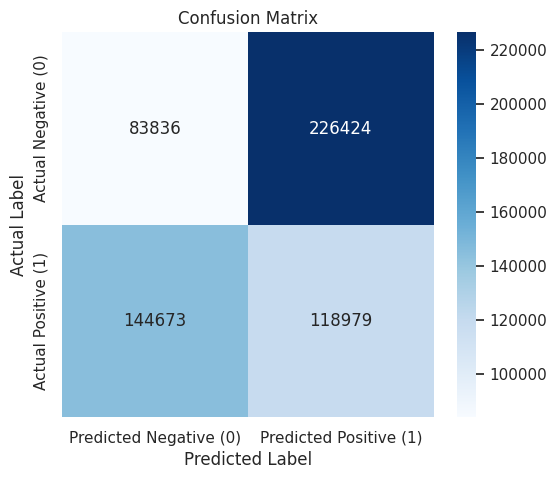

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

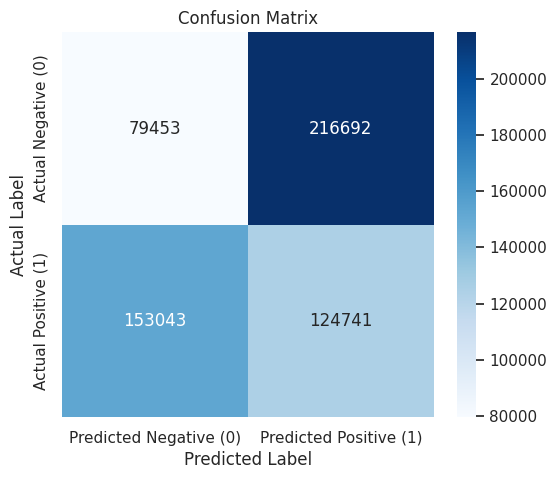

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

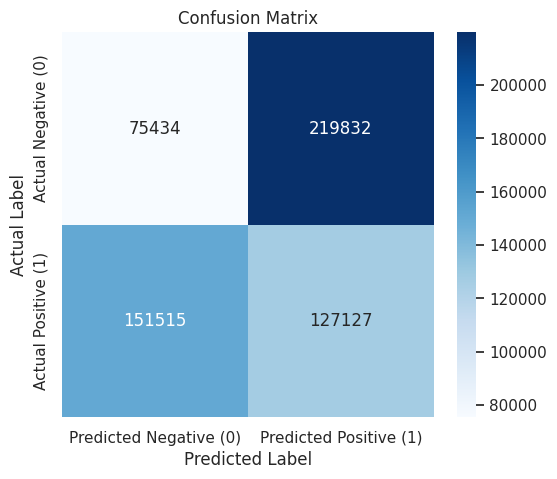

  → Selected metric (f2_score): 0.429738
New best score!
[2/20] Testing parameter combination:
  elasticNetParam: 0
  maxIter: 5
  regParam: 0.1


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

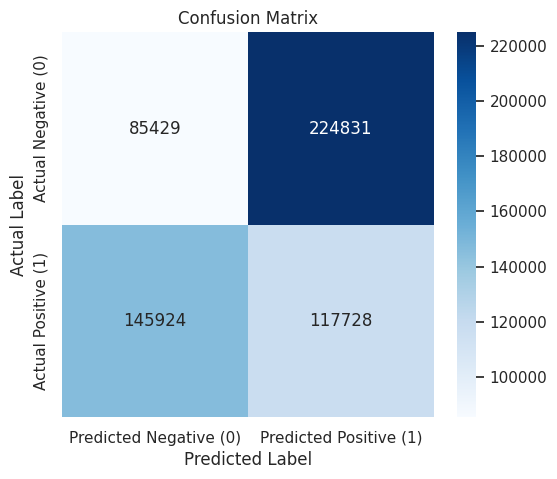

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

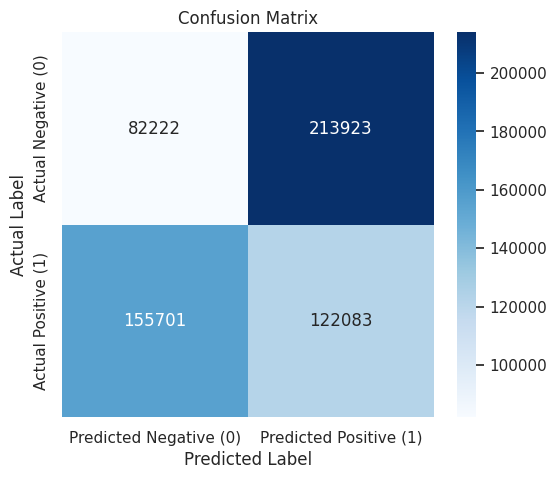

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

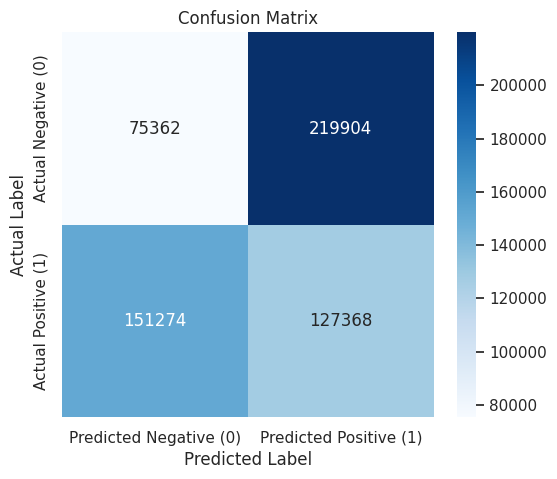

  → Selected metric (f2_score): 0.426253
[3/20] Testing parameter combination:
  elasticNetParam: 0
  maxIter: 10
  regParam: 0.01


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

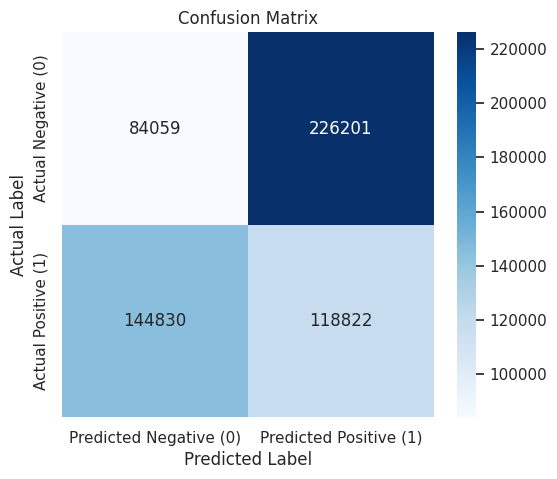

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

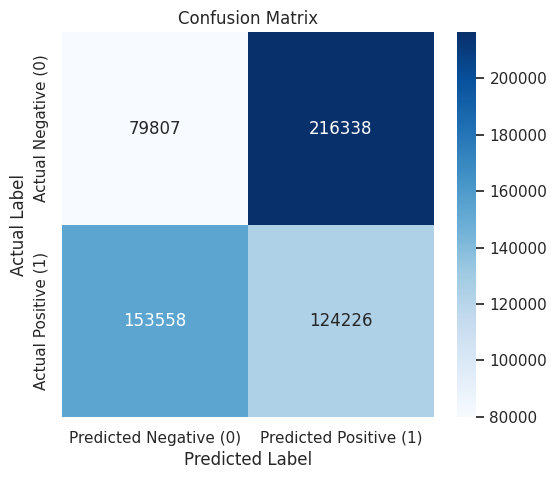

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

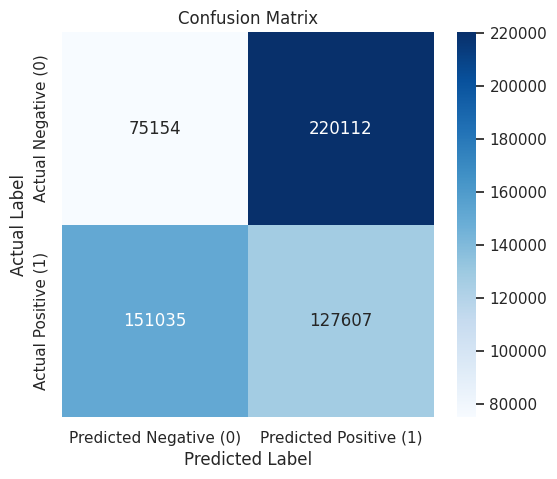

  → Selected metric (f2_score): 0.429556
[4/20] Testing parameter combination:
  elasticNetParam: 0
  maxIter: 10
  regParam: 0.1


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

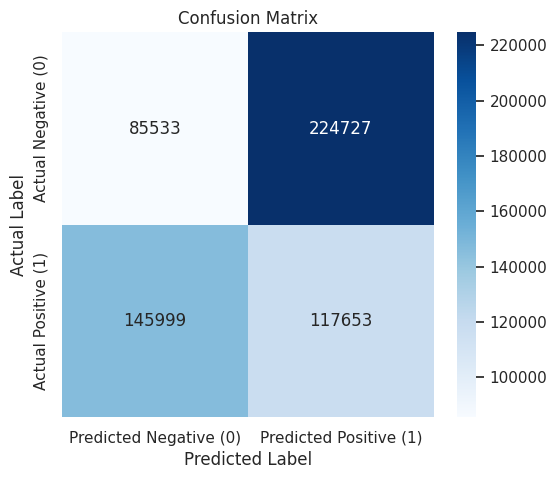

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

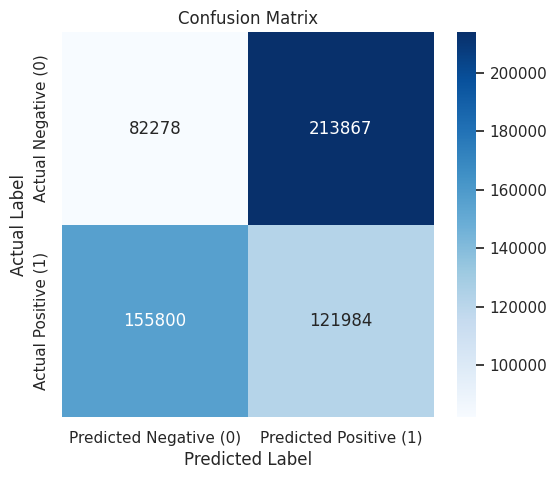

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

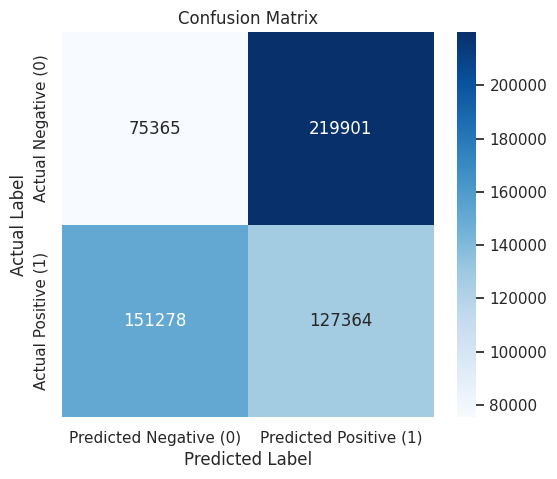

  → Selected metric (f2_score): 0.426079
[5/20] Testing parameter combination:
  elasticNetParam: 0.25
  maxIter: 5
  regParam: 0.01


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

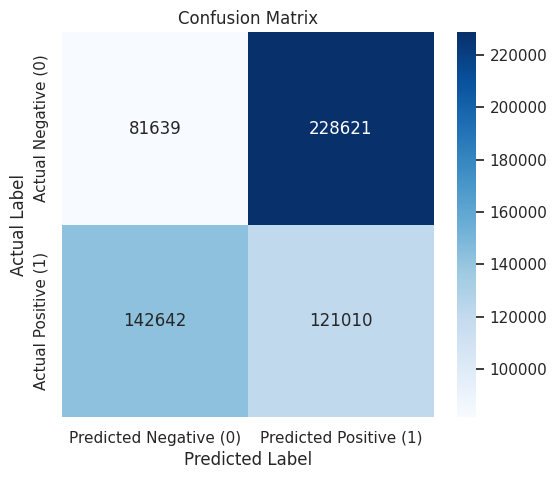

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

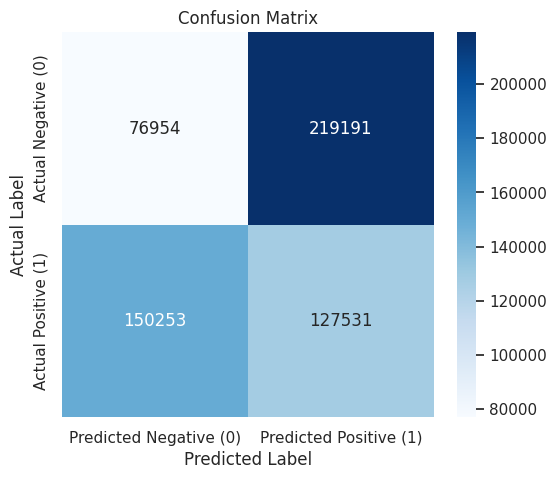

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

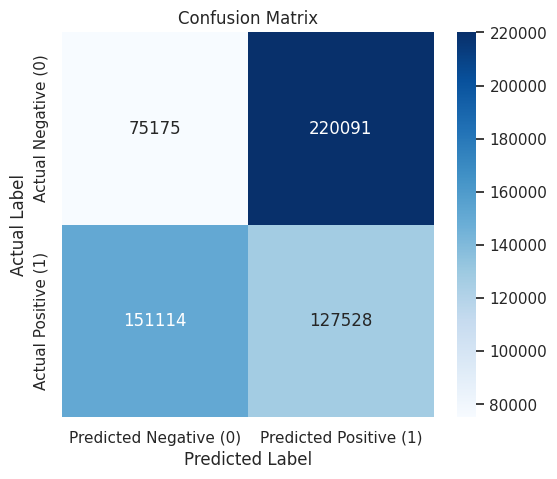

  → Selected metric (f2_score): 0.434784
New best score!
[6/20] Testing parameter combination:
  elasticNetParam: 0.25
  maxIter: 5
  regParam: 0.1


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

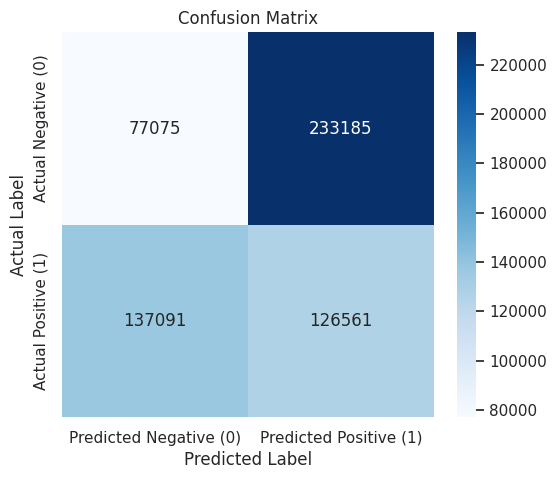

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

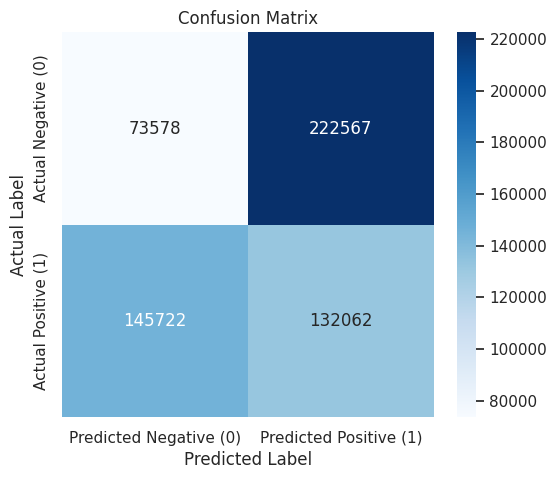

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

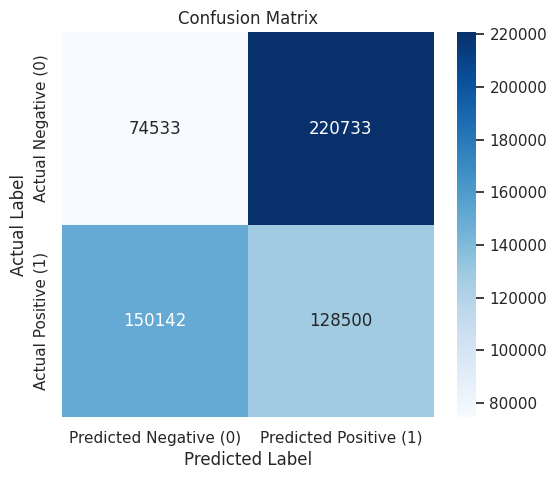

  → Selected metric (f2_score): 0.445610
New best score!
[7/20] Testing parameter combination:
  elasticNetParam: 0.25
  maxIter: 10
  regParam: 0.01


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

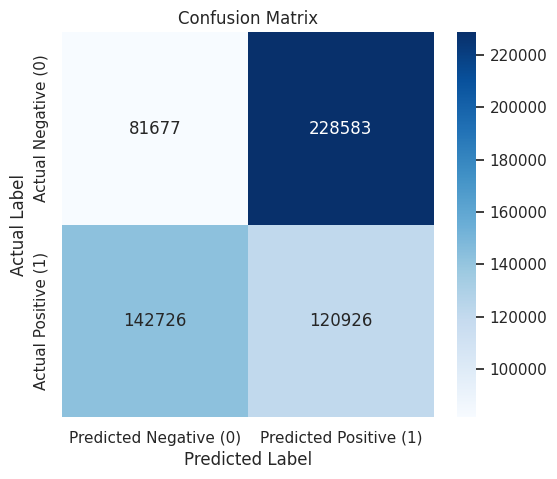

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

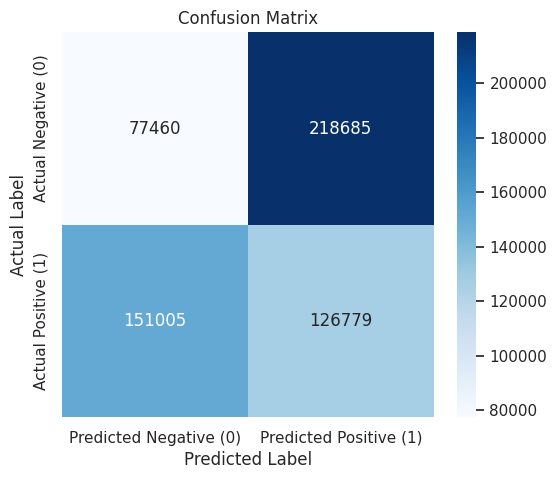

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

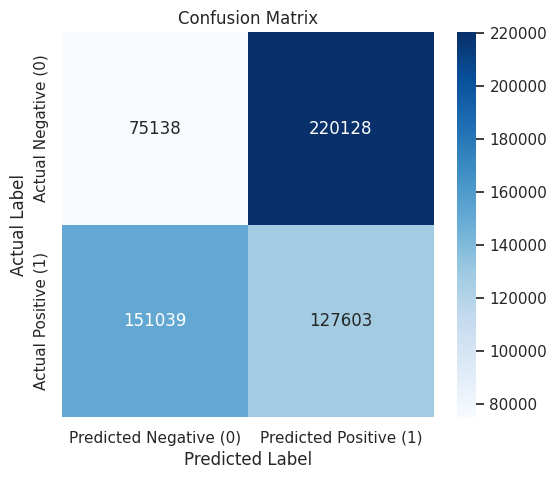

  → Selected metric (f2_score): 0.434037
[8/20] Testing parameter combination:
  elasticNetParam: 0.25
  maxIter: 10
  regParam: 0.1


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

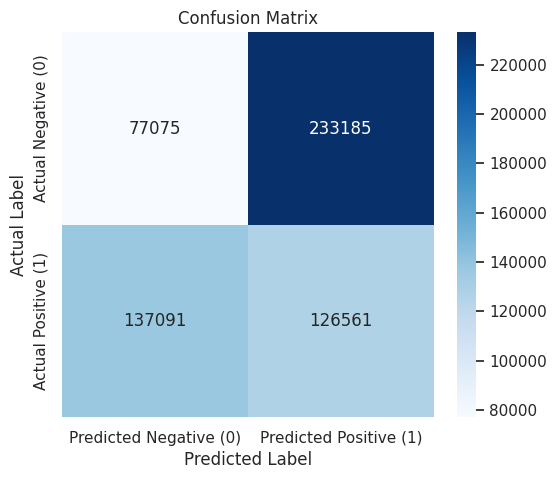

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

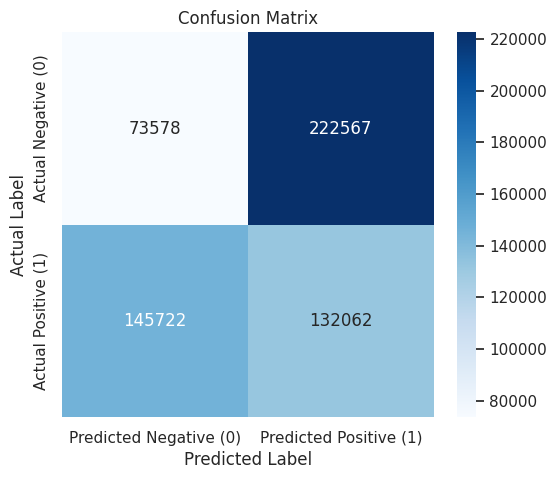

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

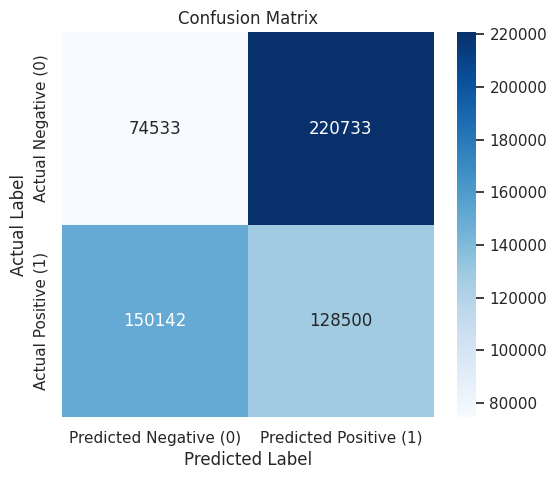

  → Selected metric (f2_score): 0.445610
[9/20] Testing parameter combination:
  elasticNetParam: 0.5
  maxIter: 5
  regParam: 0.01


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

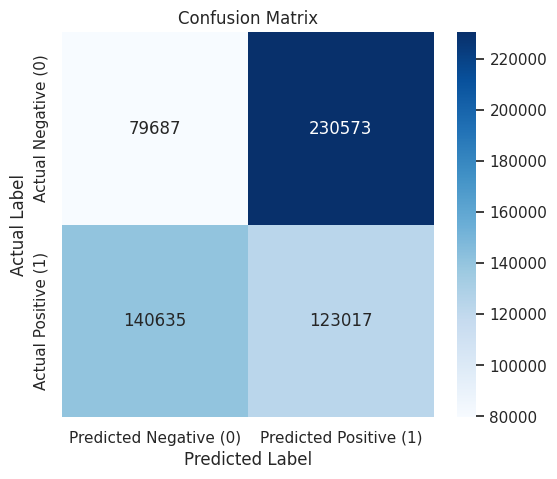

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

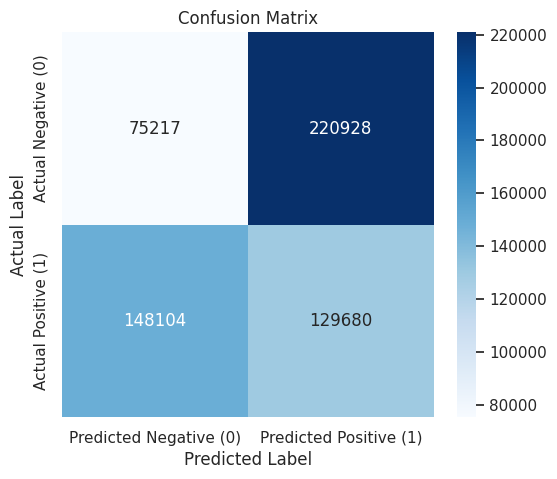

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

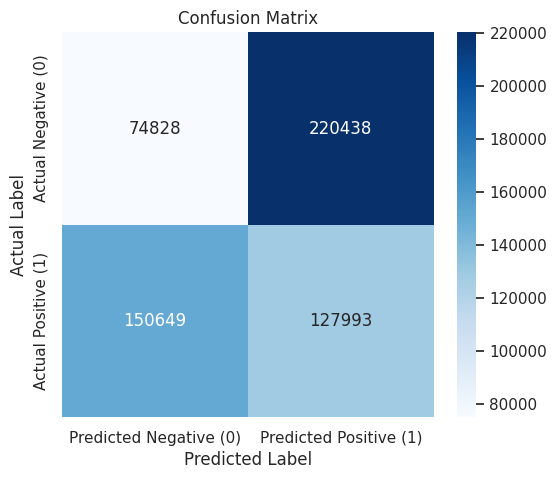

  → Selected metric (f2_score): 0.439267
[10/20] Testing parameter combination:
  elasticNetParam: 0.5
  maxIter: 5
  regParam: 0.1


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

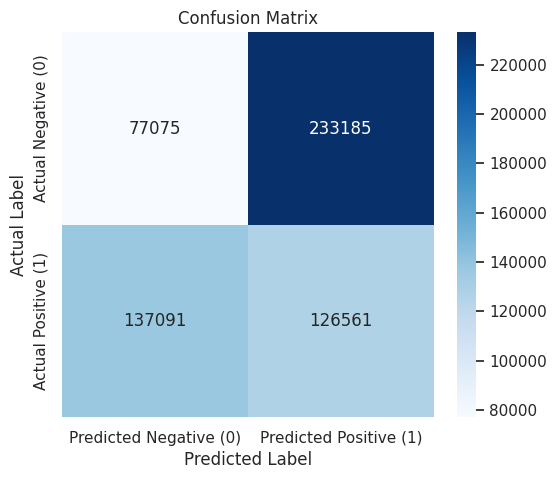

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

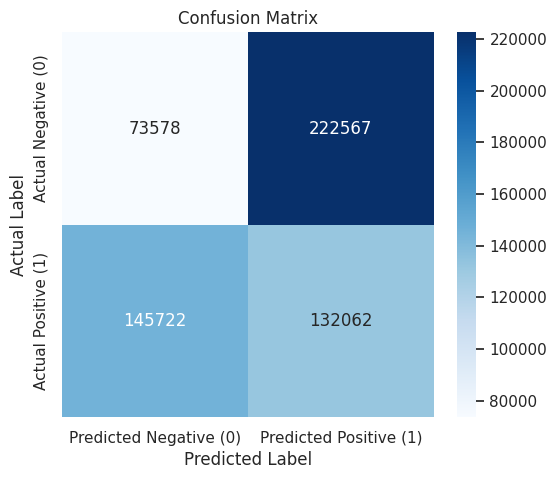

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

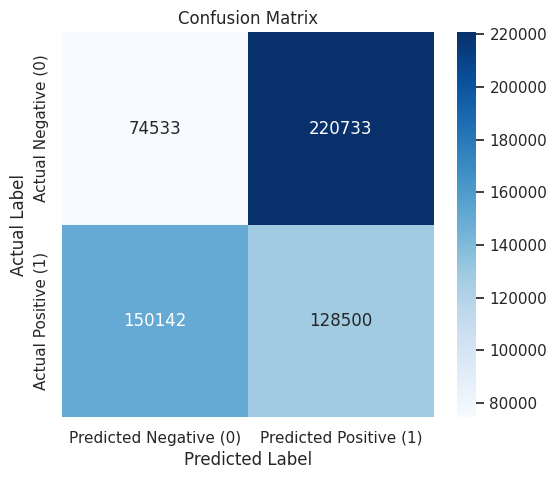

  → Selected metric (f2_score): 0.445610
[11/20] Testing parameter combination:
  elasticNetParam: 0.5
  maxIter: 10
  regParam: 0.01


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

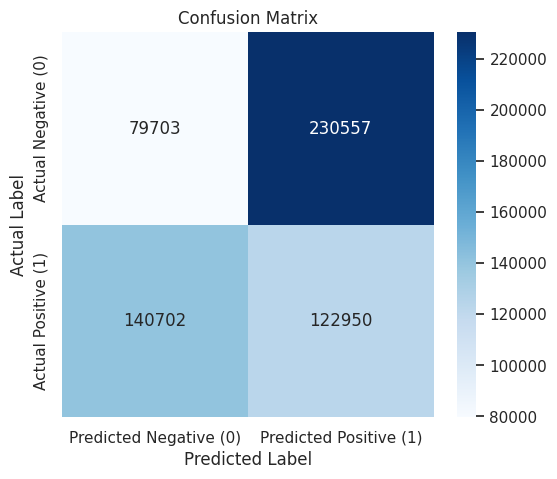

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

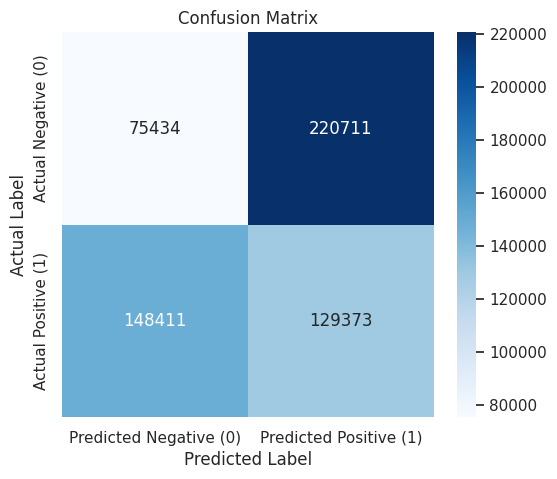

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

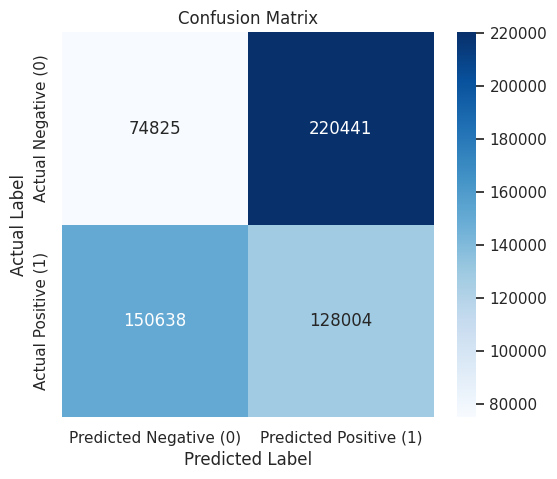

  → Selected metric (f2_score): 0.438911
[12/20] Testing parameter combination:
  elasticNetParam: 0.5
  maxIter: 10
  regParam: 0.1


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

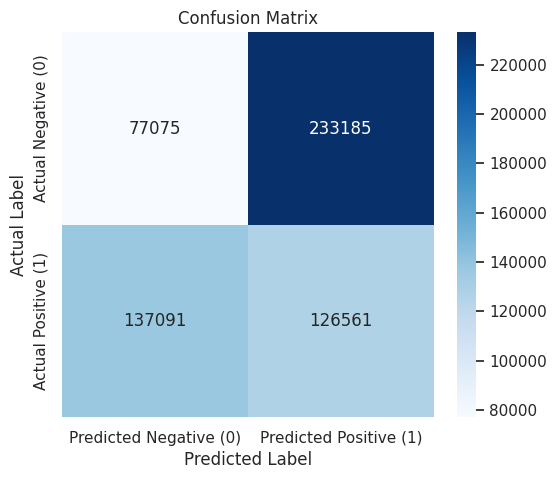

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

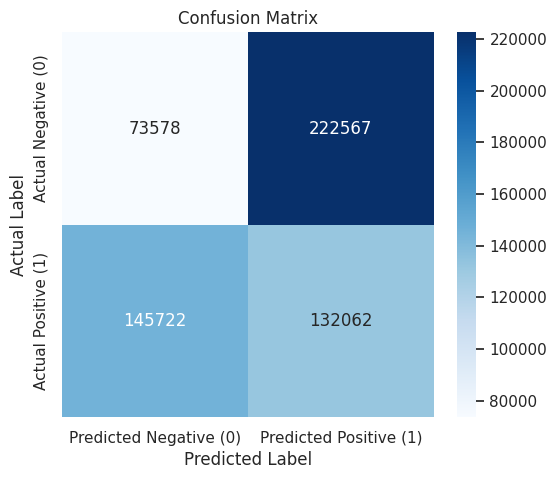

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

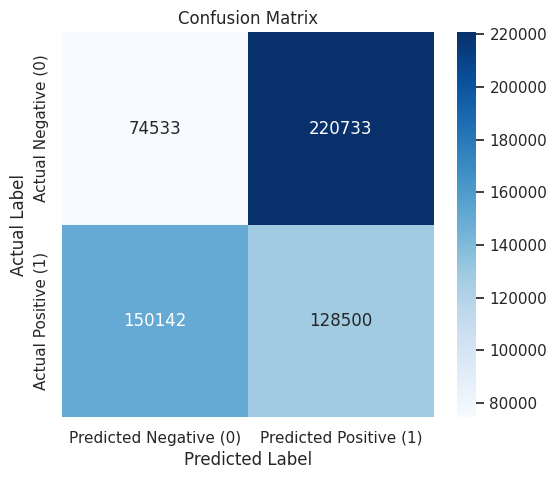

  → Selected metric (f2_score): 0.445610
[13/20] Testing parameter combination:
  elasticNetParam: 0.75
  maxIter: 5
  regParam: 0.01


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

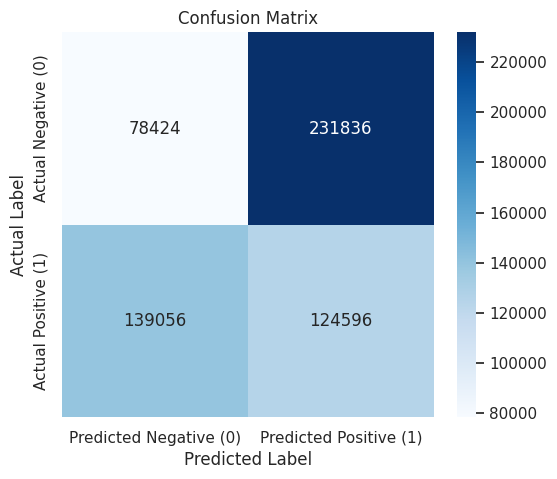

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

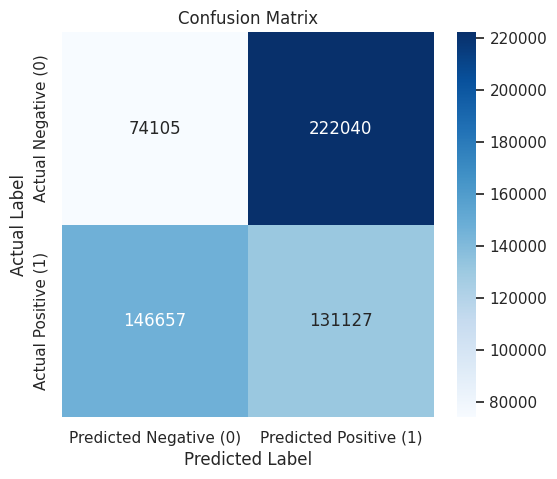

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

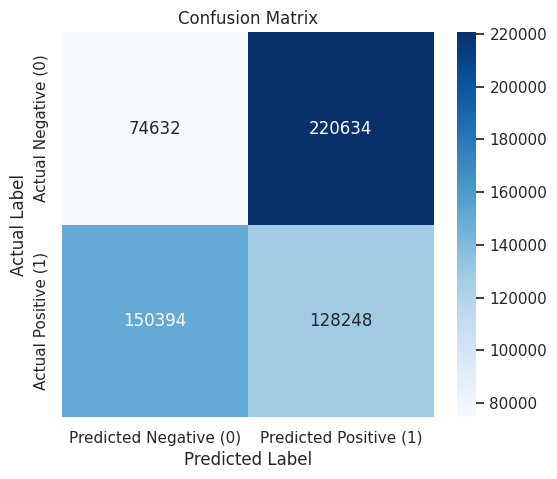

  → Selected metric (f2_score): 0.442473
[14/20] Testing parameter combination:
  elasticNetParam: 0.75
  maxIter: 5
  regParam: 0.1


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

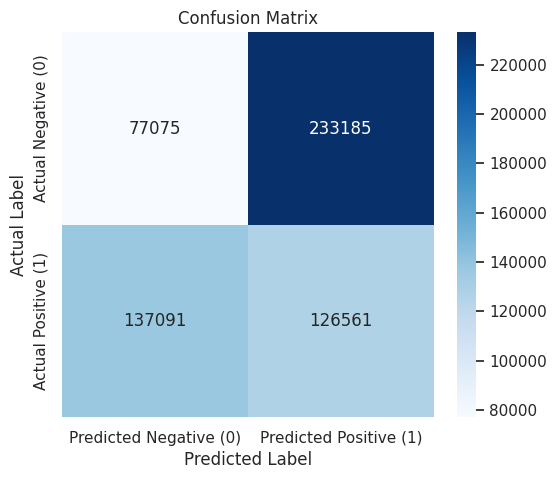

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

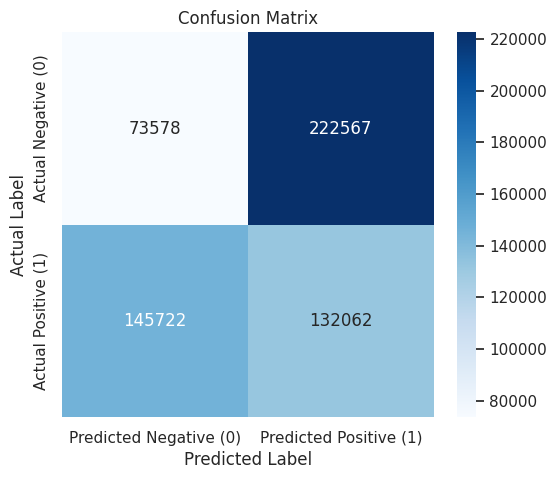

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

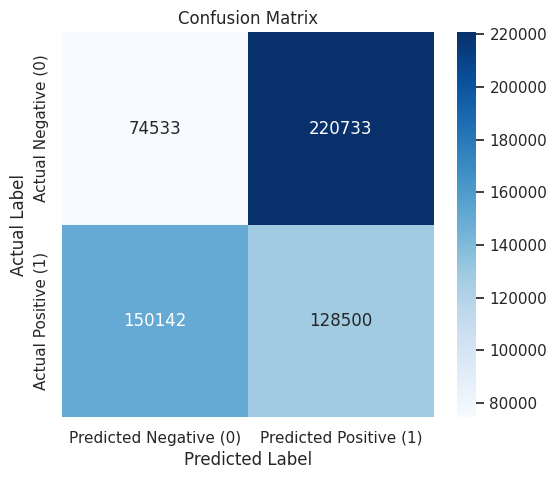

  → Selected metric (f2_score): 0.445610
[15/20] Testing parameter combination:
  elasticNetParam: 0.75
  maxIter: 10
  regParam: 0.01


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

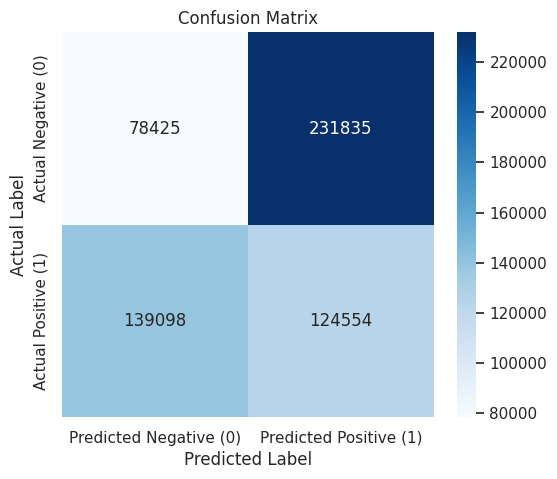

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

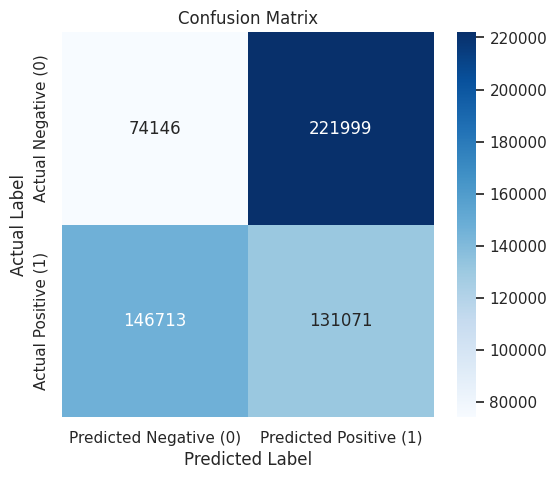

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

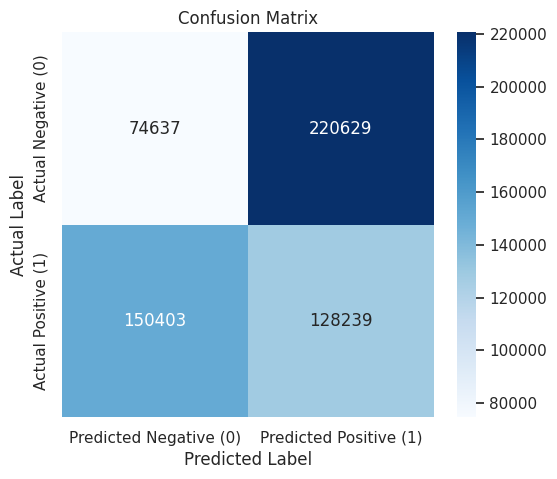

  → Selected metric (f2_score): 0.442365
[16/20] Testing parameter combination:
  elasticNetParam: 0.75
  maxIter: 10
  regParam: 0.1


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

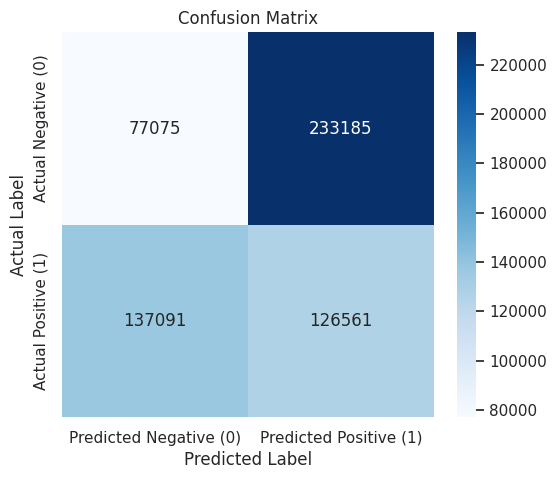

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

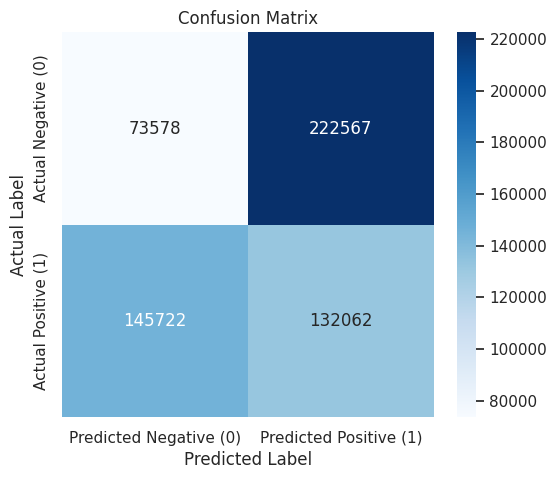

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

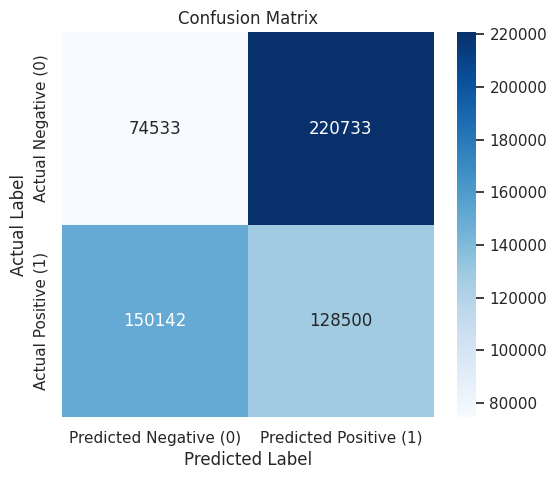

  → Selected metric (f2_score): 0.445610
[17/20] Testing parameter combination:
  elasticNetParam: 1
  maxIter: 5
  regParam: 0.01


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

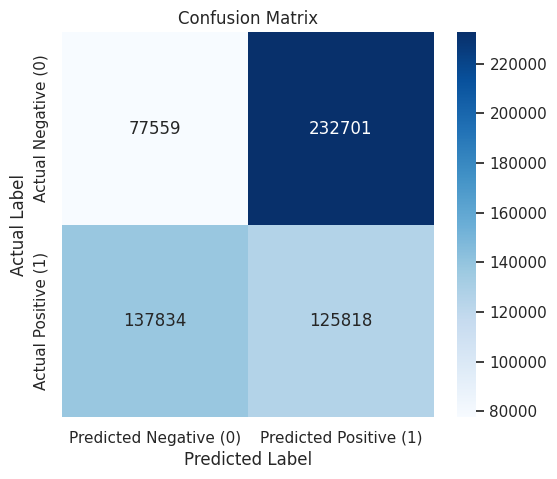

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

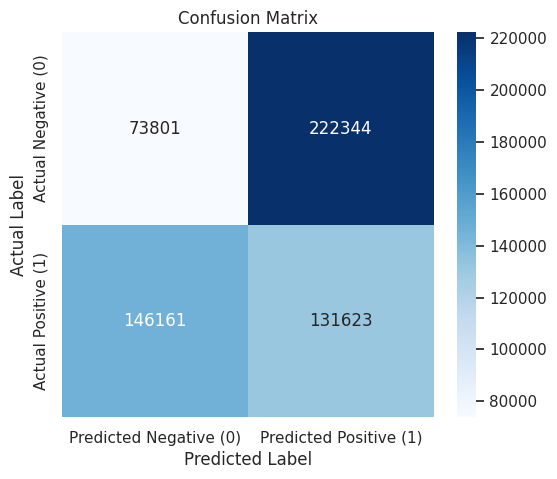

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

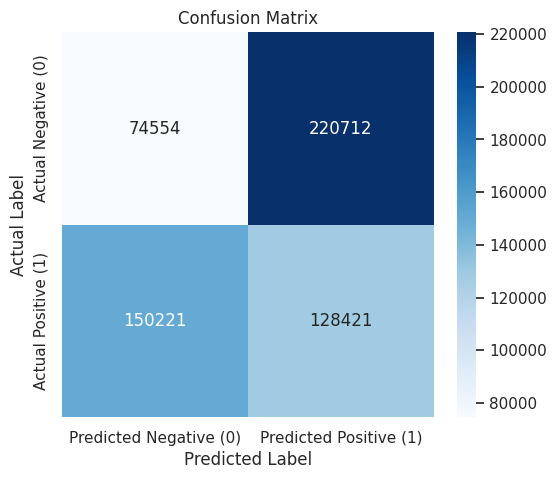

  → Selected metric (f2_score): 0.444352
[18/20] Testing parameter combination:
  elasticNetParam: 1
  maxIter: 5
  regParam: 0.1


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

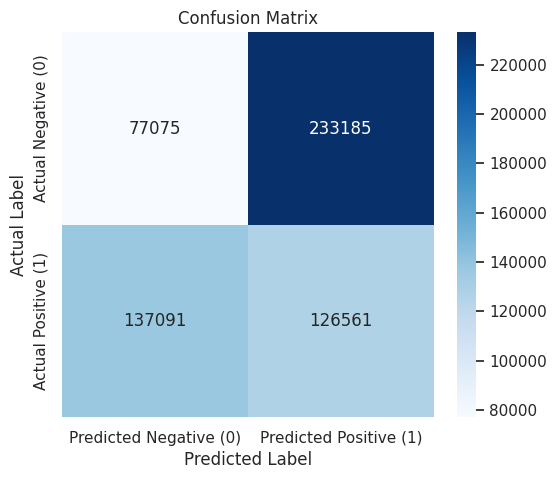

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

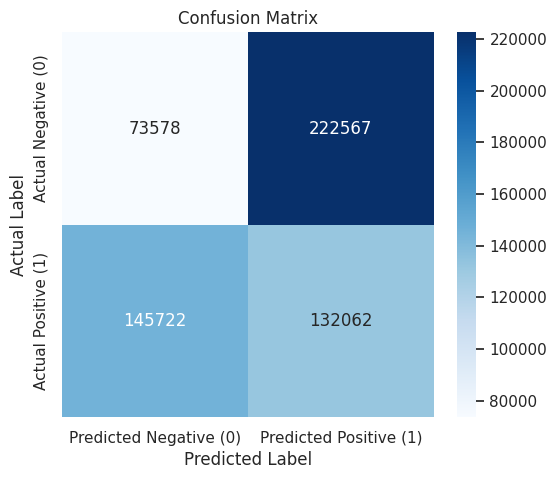

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

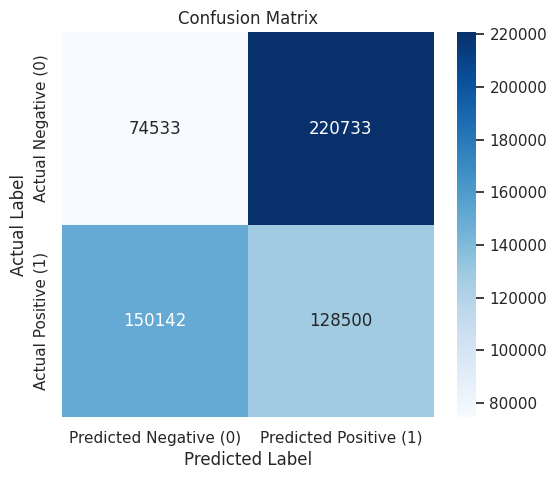

  → Selected metric (f2_score): 0.445610
[19/20] Testing parameter combination:
  elasticNetParam: 1
  maxIter: 10
  regParam: 0.01


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

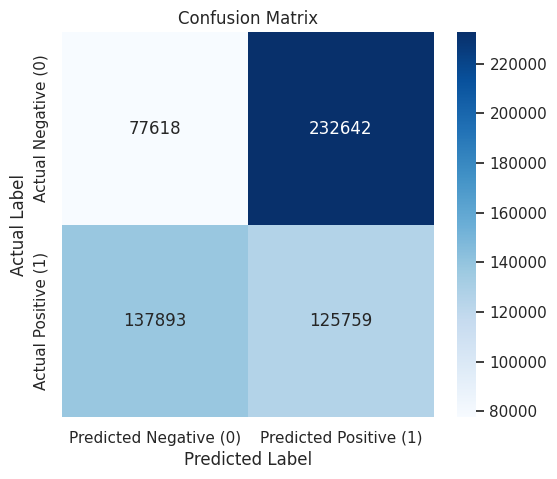

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

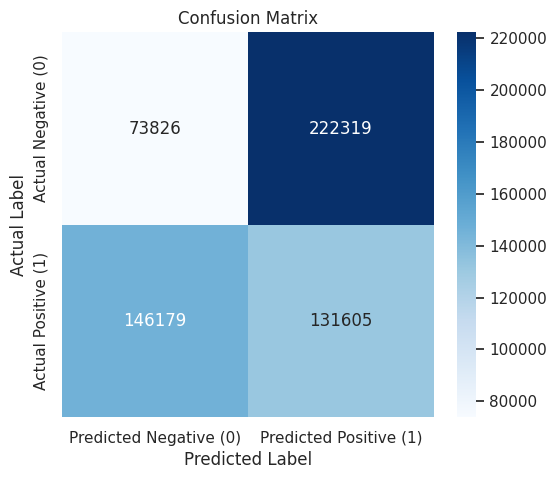

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

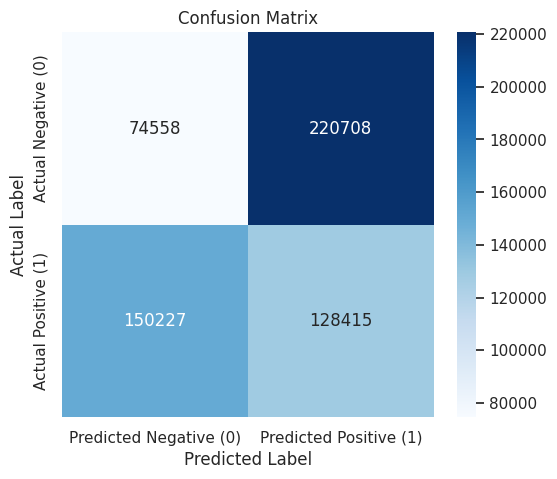

  → Selected metric (f2_score): 0.444273
[20/20] Testing parameter combination:
  elasticNetParam: 1
  maxIter: 10
  regParam: 0.1


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

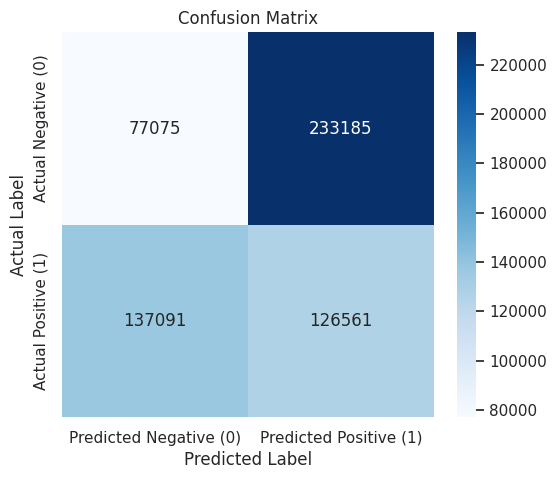

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

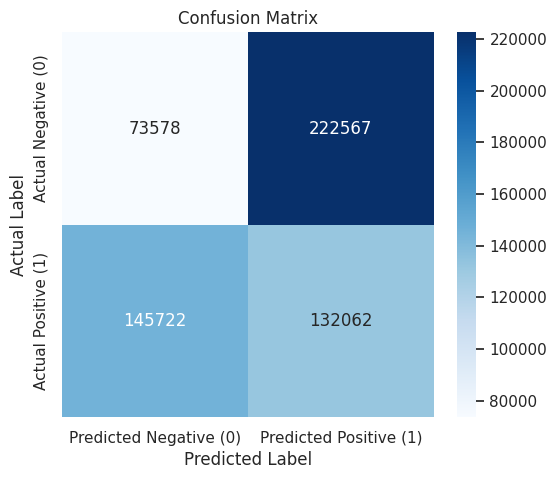

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

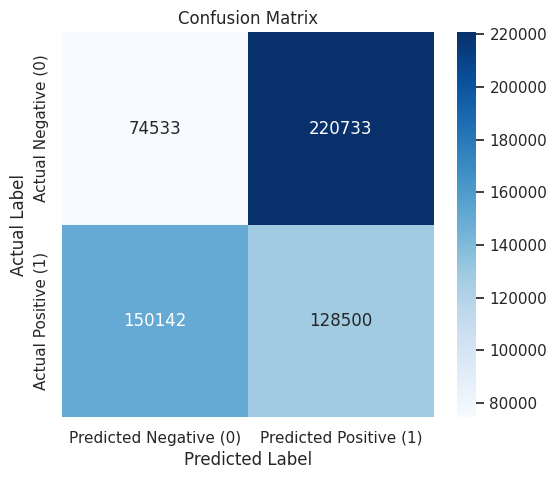

  → Selected metric (f2_score): 0.445610
Best parameter combination found:
  elasticNetParam: 0.25
  maxIter: 5
  regParam: 0.1
Best f2_score: 0.445610


In [0]:
p = {'elasticNetParam': [0,0.25,0.5,0.75,1],
     'maxIter' : [5,10],
     'regParam':[0.01,0.1]}


best_parameters, best_score = timeSeriesSplitCV(df_train_downsampled, param_grid=p, pipeline_func=lr_pipeline, model_type='lr', blocking=True ,metric='f2_score')

In [0]:
print(best_parameters)
print(best_score)

{'elasticNetParam': 0.25, 'maxIter': 5, 'regParam': 0.1}
0.44561012359114965



| # | Model Parameters | Blocked Time Split CV F2 Score|
|----|------------------|--------------------------------|
| 1 | maxIter: 5, regParam: 0.01, elasticNetParam: 0 | 0.429738|
| 2 | maxIter: 5, regParam: 0.1, elasticNetParam: 0 | 0.426253|
| 3 | maxIter: 10, regParam: 0.01, elasticNetParam: 0 | 0.429556|
| 4 | maxIter: 10, regParam: 0.1, elasticNetParam: 0 | 0.426079|
| 5 | maxIter: 5, regParam: 0.01, elasticNetParam: 0.25 | 0.434784|
| 6 | **maxIter: 5, regParam: 0.1, elasticNetParam: 0.25** | 0.445610|
| 7 | maxIter: 10, regParam: 0.01, elasticNetParam: 0.25 | 0.434037|
| 8 | maxIter: 10, regParam: 0.1, elasticNetParam: 0.25 | 0.445610|
| 9 | maxIter: 5, regParam: 0.01, elasticNetParam: 0.5 | 0.439267|
| 10 | maxIter: 5, regParam: 0.1, elasticNetParam: 0.5 | 0.445610|
| 11 | maxIter: 10, regParam: 0.01, elasticNetParam: 0.5 | 0.438911|
| 12 | maxIter: 10, regParam: 0.1, elasticNetParam: 0.5 |  0.445610|
| 13 | maxIter: 5, regParam: 0.01, elasticNetParam: 0.75 |  0.442473|
| 14 | maxIter: 5, regParam: 0.1, elasticNetParam: 0.75 |  0.445610|
| 15 | maxIter: 10, regParam: 0.01, elasticNetParam: 0.75 |  0.442365|
| 16 | maxIter: 10, regParam: 0.1, elasticNetParam: 0.75 |  0.445610|
| 17 | maxIter: 5, regParam: 0.01, elasticNetParam: 1 |  0.444352|
| 18 | maxIter: 5, regParam: 0.1, elasticNetParam: 1 |  0.445610|
| 19 | maxIter: 10, regParam: 0.01, elasticNetParam: 1 |  0.444273|
| 20 | maxIter: 10, regParam: 0.1, elasticNetParam: 1 |  0.445610|

# Final Training

In [0]:
import time

In [0]:
# Train final model on full training data using lr
model_type = 'lr'
pipeline_lr = get_model(model_type, lr_pipeline, best_parameters)

start_time = time.time()
lr_model_60m = pipeline_lr.fit(df_train_downsampled)
print("--- %s seconds ---" % (time.time() - start_time))

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

--- 80.75837445259094 seconds ---


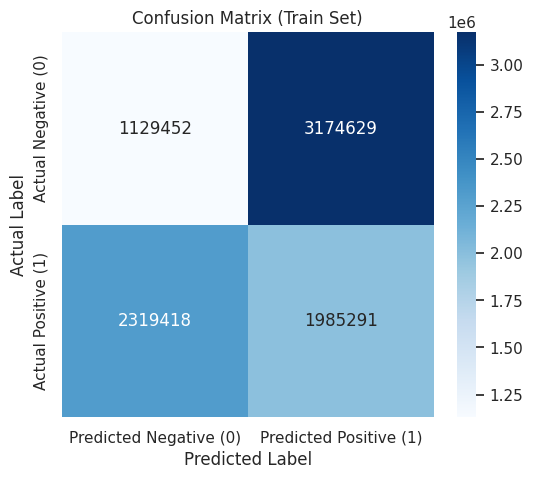

In [0]:
# evaluate model performance on training dataset
train_predictions_lr = lr_model_60m.transform(df_train_downsampled)
precision_train, recall_train, f1_train, f2_train, roc_auc_train, pr_auc_train = evaluate_classification_model_train_test(prediction=train_predictions_lr,evaluation_type='train')

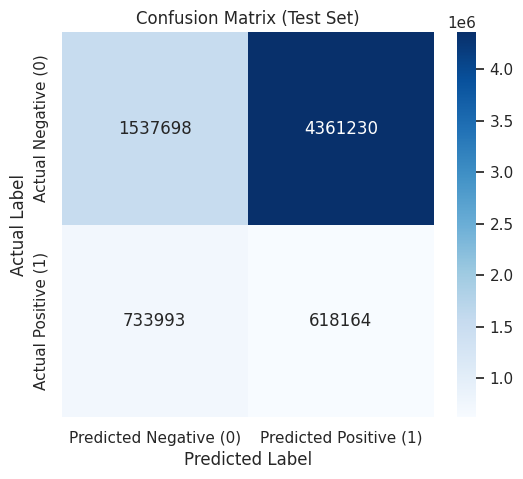

In [0]:
# evaluate model performance on test dataset
test_predictions_lr = lr_model_60m.transform(df_test.dropna())
precision_test, recall_test, f1_test, f2_test, roc_auc_test, pr_auc_test = evaluate_classification_model_train_test(prediction=test_predictions_lr,evaluation_type='test')

In [0]:
print("Train f2 score",f2_train)
print("Test f2 score",f2_test)

Train f2 score 0.4435659873140402
Test f2 score 0.2975369131871304


# Testing Model Loading For Ensemble of Ensembles

In [0]:
%python
# Import the mlflow module
import mlflow

# Load ml model from dbfs:/databricks/mlflow-tracking/1536813829684263/772d71be6767463db23cabcec64011b9/artifacts/model
baseline_model = mlflow.spark.load_model("dbfs:/databricks/mlflow-tracking/1536813829684263/772d71be6767463db23cabcec64011b9/artifacts/model")

# use model to make predictions on df_train_downsampled data
train_predictions_lr = baseline_model.transform(df_train_downsampled)

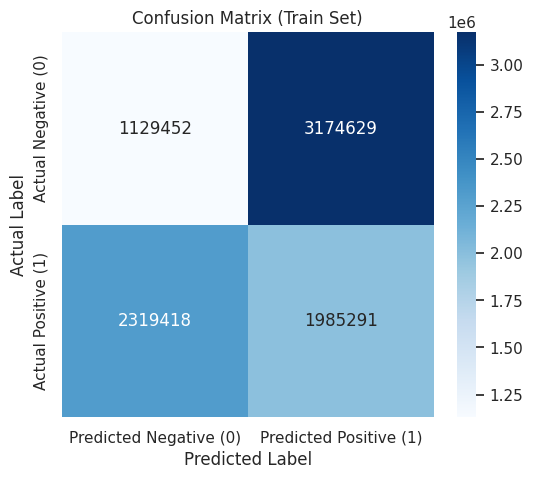

In [0]:
# use model to make predictions on df_train_downsampled data
train_predictions_lr = baseline_model.transform(df_train_downsampled)
precision_train, recall_train, f1_train, f2_train, roc_auc_train, pr_auc_train = evaluate_classification_model_train_test(prediction=train_predictions_lr,evaluation_type='train')

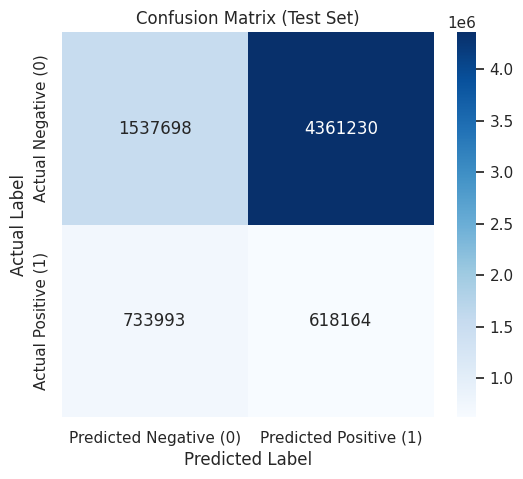

In [0]:
# evaluate model performance on test dataset
test_predictions_lr = baseline_model.transform(df_test.dropna())
precision_test, recall_test, f1_test, f2_test, roc_auc_test, pr_auc_test = evaluate_classification_model_train_test(prediction=test_predictions_lr,evaluation_type='test')

In [0]:
print("Train f2 score",f2_train)
print("Test f2 score",f2_test)

Train f2 score 0.4435659873140402
Test f2 score 0.2975369131871304
